# Data Processing

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
import pickle
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.process import *
from utils.plot_functions import mk_pie_plot, mk_data_summary_plot

In [2]:
base_dir = pjoin(os.environ['HOME'], 'Documents/A1')
data_dir = pjoin(base_dir, 'Data')
results_dir = pjoin(base_dir, 'results')

Get raw data and organize it in python h5 files.  Data processing:

- First step was to remove traces that contained NaN.  This sometimes meant removing entire trials that had NaN for all neurons in the experiment, and sometime meant removing neurons that had NaN in all their trials.
- Next step was to identify and remove outlier neurons.

In [3]:
nb_std = 1
organize_data(base_dir, nb_std=nb_std)

[INFO] file found. exiting...




## Print data summary

In [4]:
processed_dir = pjoin(base_dir, 'python_processed')
h_load_file = pjoin(processed_dir, "organized_nb_std={:d}.h5".format(nb_std))

summary_data = summarize_data(h_load_file)

*** Data Summary ***
---------------------------------------------
- num experiments: 34,
- num animals: 9,
- num good cells: 2457,    
- num behavior trials 3953,
- num passive trials 1839,    

- num/percent different trials:
	○ correctreject: 1411 (36%)
	○ hit: 1180 (30%)
	○ earlyhit: 411 (10%)
	○ falsealarm: 329 (8%)
	○ miss: 295 (7%)
	○ early: 199 (5%)
	○ earlyfalsealarm: 123 (3%)

- percent frequencies used (behavior):
	○ 7000 Hz: 26%
	○ 9899 Hz: 26%
	○ 14000 Hz: 25%
	○ 19799 Hz: 25%

- percent frequencies used (passive):
	○ 4000 Hz: 7%
	○ 5000 Hz: 6%
	○ 5657 Hz: 7%
	○ 7071 Hz: 6%
	○ 8000 Hz: 7%
	○ 10000 Hz: 6%
	○ 11314 Hz: 7%
	○ 14142 Hz: 6%
	○ 16000 Hz: 7%
	○ 20000 Hz: 6%
	○ 22627 Hz: 7%
	○ 28284 Hz: 6%
	○ 32000 Hz: 7%
	○ 40000 Hz: 6%
	○ 45255 Hz: 7%
	○ 56569 Hz: 6%

- percent stim levels used (behavior):
	○ 75 dB: 77%
	○ 70 dB: 11%
	○ 55 dB: 8%
	○ 60 dB: 5%

- percent stim levels used (passive):
	○ 75 dB: 46%
	○ 64 dB: 35%
	○ 55 dB: 18%
	○ 60 dB: 3%
---------------------------

### Pie chart as a visual summary

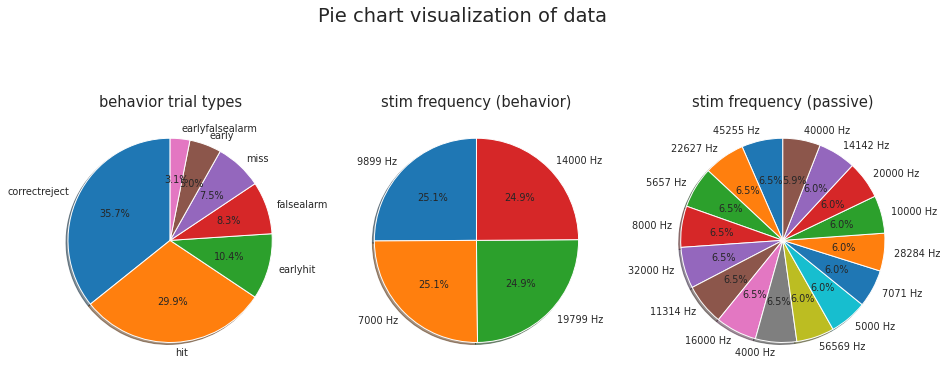

In [5]:
_ = mk_pie_plot(
    summary_data,
    figsize=(16, 7),
    dpi=70,
)

### Outlier removal

To ensure results are not corrupted by noisy samples, I identify a small subset of neurons as outliers and remove them.  To detect these neurons, I calculated the $p$-norm for 2 values of $p = 2$ and $p = \inf$.   Then removed neurons with a norm that was $n_{std} = 1$ std away from the mean norm.  I think what Manasij did was similar to $p = \inf$ case.  I decided to use $p = 2$ instead since the end result didn’t really change.  Here is percentage of neurons removed depending on the threshold:

- **1 std:   8.92 % removed**
- 2 std:   4.68 % removed
- 3 std:   2.37 % removed
- 5 std:   0.77% removed

This figure compares an example outlier neuron's trace to other neurons form the same experiment/trial.

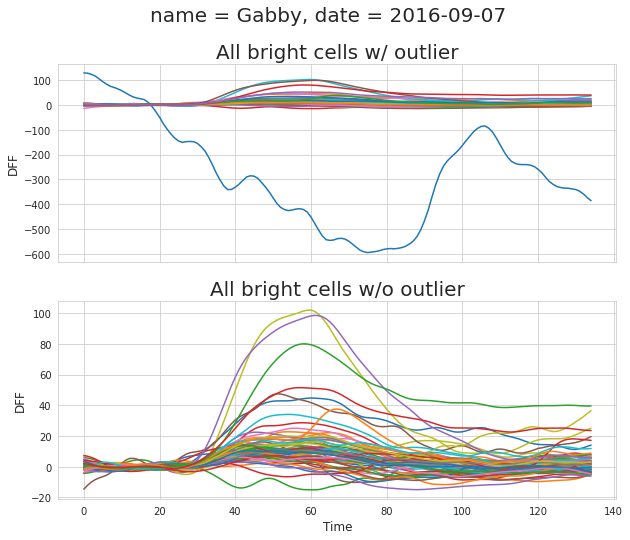

In [5]:
from pathlib import Path
data_dir = pjoin(base_dir, 'Data')

for path in Path(data_dir).rglob('*.pkl'):
    file = str(path)
    data = pickle.load(open(file, "rb"))
    if data[0]['name'] == "Gabby" and data[0]['date'] == "2016-09-07":
        break

bright_cells = data[0]['bright_cells']
hit = data[0]['hit']
dff = data[0]['dff']

dff = dff[..., bright_cells == 1][:, hit == 1, :]

sns.set_style('whitegrid')
fig, ax_arr = plt.subplots(2, 1, figsize=(10, 8), sharex='col')

ax_arr[0].plot(dff.mean(1))
ax_arr[0].set_ylabel("DFF", fontsize=12)
ax_arr[0].set_title("All bright cells w/ outlier", fontsize=20)

ax_arr[1].plot(dff[..., 1:].mean(1))
ax_arr[1].set_xlabel("Time", fontsize=12)
ax_arr[1].set_ylabel("DFF", fontsize=12)
ax_arr[1].set_title("All bright cells w/o outlier", fontsize=20)

plt.suptitle("name = {}, date = {}".format(data[0]['name'], data[0]['date']), fontsize=20)
plt.show()

## Plot average traces, licks etc

load the data

In [243]:
load_df_file = pjoin(processed_dir, 'processed_nb_std={:d}'.format(nb_std), "all.df")
df_all = pd.read_pickle(load_df_file)

### Average responses for different behavior frequencies

- target: 7, 10 kHz
- nontarget: 14, 20, kHz

Avg across all experiments. Passive trials also included.  Interestingly, at f = 14kHz avg traces for passive and falsealarm trials overlap almost perfectly.

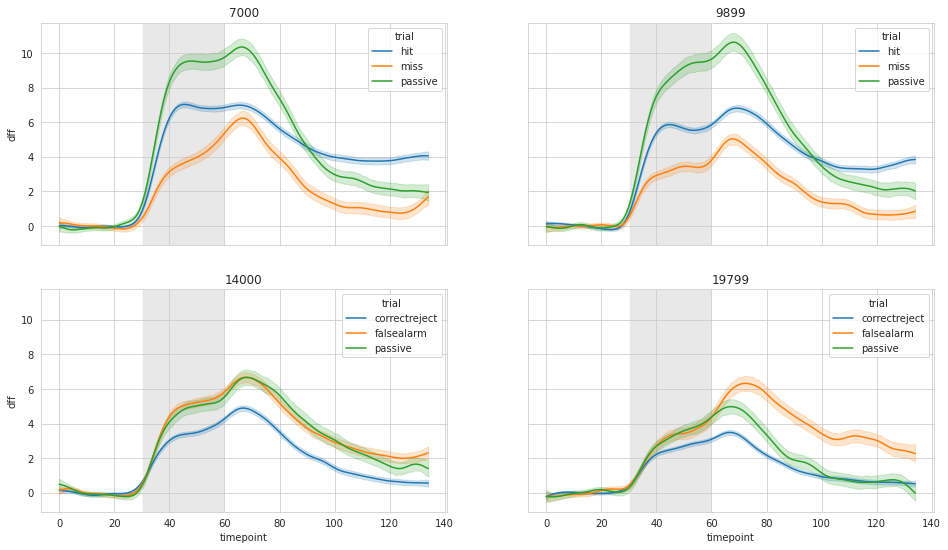

In [8]:
behavior_freqs = sorted(df_all.loc[df_all.trial != 'passive'].stimfreq.unique())

sns.set_style('whitegrid')
fig, ax_arr = plt.subplots(2, 2, figsize=(16, 9), sharex='all', sharey='all')
for idx, freq in enumerate(behavior_freqs):
    i, j = idx // 2, idx % 2
    
    if freq == 7000:
        freq_list = [freq, 7071]
        trials_list = ['hit', 'miss']
    elif freq == 9899:
        freq_list = [freq, 10000]
        trials_list = ['hit', 'miss']
    elif freq == 14000:
        freq_list = [freq, 14142]
        trials_list = ['correctreject', 'falsealarm']
    elif freq == 19799:
        freq_list = [freq, 20000]
        trials_list = ['correctreject', 'falsealarm']
    trials_list.extend(['passive'])
    
    selected_df = df_all.loc[(df_all.stimfreq.isin(freq_list)) & (df_all.trial.isin(trials_list))]
    sns.lineplot(data=selected_df, x='timepoint', y='dff',
                 hue='trial', hue_order=trials_list, ax=ax_arr[i, j])
    ax_arr[i, j].axvspan(30, 60, facecolor='lightgrey', alpha=0.5, zorder=0)
    ax_arr[i, j].set_title(freq)
plt.show()

### Average responses for different passive frequencies

Avg over all passive trials. The bar plot shows a clear distinction between target (7, 10 kHz) and nontarget (14, 20 kHz) frequencies vs the rest.  As a result of intense training, the animals become much more selective to these frequencies.  The only anomaly here is at 5kHz.  What could cause this increase in response intensity?  This is not explainable by saying 5k is close to 7k, because then what about 5.6 k?

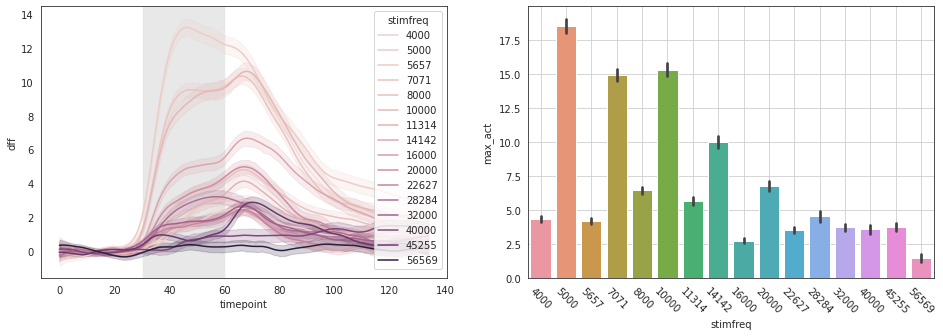

In [9]:
sns.set_style('white')
fig, ax_arr = plt.subplots(1, 2, figsize=(16, 5))

selected_df = df_all.loc[df_all.trial == 'passive']
ax_arr[0].axvspan(30, 60, facecolor='lightgrey', alpha=0.5, zorder=0)
sns.lineplot(data=selected_df, x='timepoint', y='dff', hue='stimfreq', legend='full', ax=ax_arr[0])
sns.barplot(data=selected_df.loc[selected_df.timepoint == 0], y='max_act', x='stimfreq', ax=ax_arr[1])
ax_arr[1].tick_params(axis='x', rotation=-45)
ax_arr[1].grid()

plt.show()

### Counting the number of SUP and EXC cells

To get more insights into this, here I plot the number of SUP and EXC cells during passive trials in each frequency.  Number of suppressed cells is noticably lower for behavior frequencies 7, 10, 14, and 20 kHz, plus 5 kHz.  I wonder if this is a recording artifact, or if there is a better explantion?

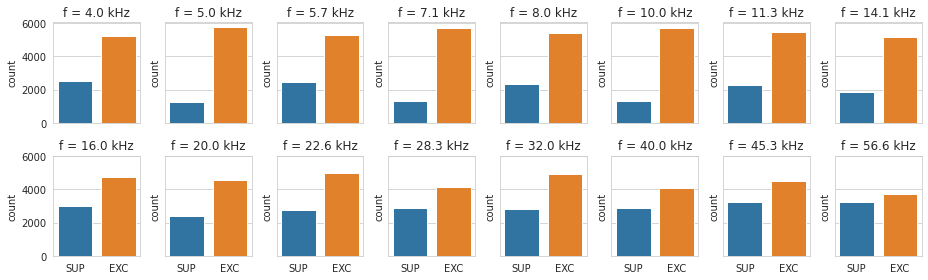

In [11]:
sns.set_style('whitegrid')
fig, ax_arr = plt.subplots(2, 8, figsize=(13, 4), sharex='all', sharey='all')

for idx, freq in enumerate(sorted(selected_df.stimfreq.unique())):
    i, j = idx // 8, idx % 8
    _df = selected_df.loc[(selected_df.timepoint == 0) & (selected_df.stimfreq == freq)]
    sns.countplot(data=_df, x='cell_tag', order=['SUP','EXC'], ax=ax_arr[i, j])
    ax_arr[i, j].set_title("f = {:.1f} kHz".format(freq / 1000))
    ax_arr[i, j].set_xlabel('')
fig.tight_layout()
plt.show()

### Average response for different trials

- top row shows average traces across neurons for given trial types. each subplot inclues:
    - avg **EXC** response (cells that on average were excited during that trial)
    - avg **SUP** response (cells that on average were suppressed during that trial)
    - avg overall
- 2nd row is average lick traces
- 3rd row shows the distribution of EXC/SUP cells for each trial type
- last row shows avg of the largest activation for EXC and SUP across trial types (if data were zscored, this plot would be more or les flat)

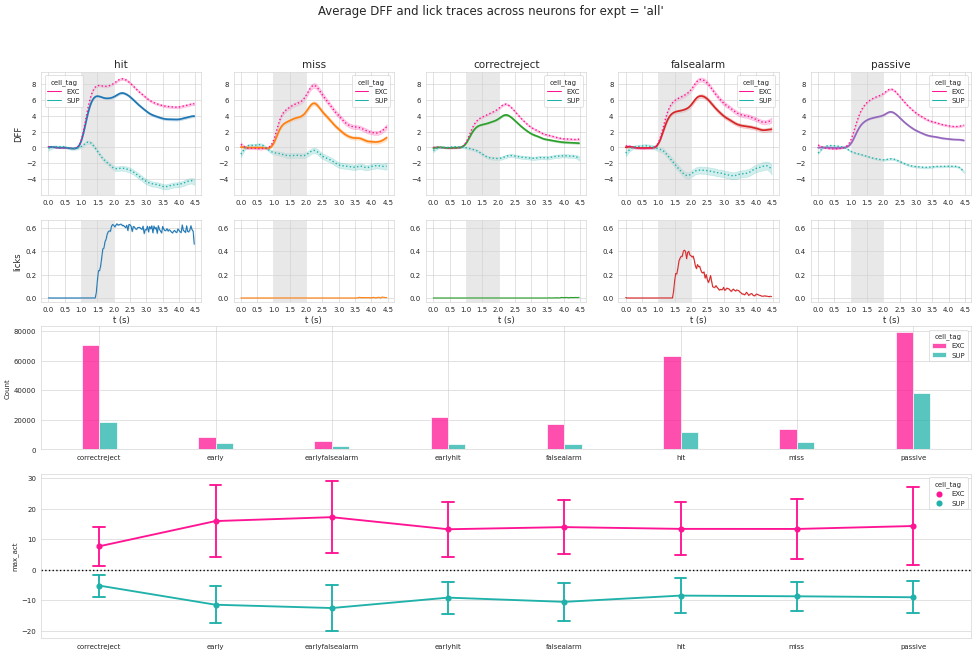

In [10]:
_ = mk_data_summary_plot(
    df=df_all,
    figsize=(24, 16),
    dpi=50,
)

## Single cells vs Population

Where is information about trial labels encoded? Can we reliably decode whether a single trace from a single cell is coming from a hit trial or a miss trial?  The answer is almost certainly not, but let's quantify it here.

In [5]:
trials = ['hit', 'miss', 'correctreject', 'falsealarm']
freqs = [7000, 9899, 14000, 19799]

l2i = {trial: i for i, trial in enumerate(trials)}
i2l = {i: lbl for lbl, i in l2i.items()}

f2i = {freq: i for i, freq in enumerate(freqs)}
i2f = {i: freq for freq, i in f2i.items()}

In [6]:
f = h5py.File(h_load_file, 'r')

dff_freq = []
dff_trial = []
df_freq = pd.DataFrame()
df_trial = pd.DataFrame()

for name in tqdm(f):
    behavior = f[name]['behavior']
    passive = f[name]['passive']

    good_cells_b = np.array(behavior["good_cells"], dtype=int)
    good_cells_p = np.array(passive["good_cells"], dtype=int)
    good_cells = set(good_cells_b).intersection(set(good_cells_p))
    good_cells = sorted(list(good_cells))

    stimfrequency = np.array(behavior['trial_info']['stimfrequency'], dtype=int)
    dff = np.array(behavior['dff'], dtype=float)[..., good_cells]
    nt, _, nc = dff.shape
    
    
    for trial in trials:
        indxs = np.where(np.array(behavior['trial_info'][trial]) == 1)[0]
        dff_trial.append(dff[:, indxs, :].reshape(nt, -1))
        
        cell_indx = np.expand_dims(range(nc), 0)
        cell_indx = np.repeat(cell_indx, len(indxs), axis=0)
        
        data_dict = {
            'cell_indx': cell_indx.flatten(),
            'trial': [trial] * len(indxs) * nc,
            'name': [name] * len(indxs) * nc,
        }
        df_trial = pd.concat([df_trial, pd.DataFrame.from_dict(data_dict)])
    
    for freq in freqs:
        indxs = np.where(stimfrequency == freq)[0]
        dff_freq.append(dff[:, indxs, :].reshape(nt, -1))

        cell_indx = np.expand_dims(range(nc), 0)
        cell_indx = np.repeat(cell_indx, len(indxs), axis=0)

        data_dict = {
            'cell_indx': cell_indx.flatten(),
            'freq': [freq] * len(indxs) * nc,
            'name': [name] * len(indxs) * nc,
        }
        df_freq = pd.concat([df_freq, pd.DataFrame.from_dict(data_dict)])
f.close()
        
df_trial = reset_df(df_trial)
df_freq = reset_df(df_freq)

100%|██████████| 34/34 [00:01<00:00, 20.85it/s]


#### Frequency

In [15]:
x = np.concatenate(dff_freq, axis=-1).T
labels = df_freq.freq.to_numpy()
x.shape, labels.shape

((251419, 135), (251419,))

In [16]:
y = np.array([f2i[item] for item in labels])

In [17]:
tst_indxs = []
trn_indxs = []

for freq in freqs:
    indxs = np.where(labels == freq)[0]
    tst_indxs.append(indxs[:len(indxs)//5])
    trn_indxs.append(indxs[len(indxs)//5:])
    
tst_indxs = np.concatenate(tst_indxs)
trn_indxs = np.concatenate(trn_indxs)

assert not set(tst_indxs).intersection(set(trn_indxs))

In [18]:
from sklearn.linear_model import LogisticRegression

trange = range(45, 75)

clf = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='lbfgs',
    max_iter=400,
    n_jobs=-1,
    class_weight='balanced',
).fit(x[trn_indxs][:, trange], y[trn_indxs])

In [19]:
from sklearn.metrics import balanced_accuracy_score

y_pred = clf.predict(x[tst_indxs][:, trange])
balanced_accuracy_score(y[tst_indxs], y_pred)

0.27155409142884673

- classifier accuracy is ~27%, performs at chance level = 25%
- we can't reliably decode stim frequency from individual calcium traces

#### Trial labels

In [7]:
x = np.concatenate(dff_trial, axis=-1).T
labels = df_trial.trial.to_numpy()
x.shape, labels.shape

((204736, 135), (204736,))

In [8]:
y = np.array([l2i[item] for item in labels])

In [9]:
tst_indxs = []
trn_indxs = []

for trial in trials:
    indxs = np.where(labels == trial)[0]
    tst_indxs.append(indxs[:len(indxs)//5])
    trn_indxs.append(indxs[len(indxs)//5:])
    
tst_indxs = np.concatenate(tst_indxs)
trn_indxs = np.concatenate(trn_indxs)

assert not set(tst_indxs).intersection(set(trn_indxs))

In [15]:
clf = LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='lbfgs',
    max_iter=400,
    n_jobs=-1,
    class_weight='balanced',
).fit(x[trn_indxs][:, trange], y[trn_indxs])

In [16]:
y_pred = clf.predict(x[tst_indxs][:, trange])
balanced_accuracy_score(y[tst_indxs], y_pred)

0.2677700838514673

- again, classifier accuracy is ~27%, performs at chance level = 25%
- we can't reliably decode trial labels from individual calcium traces

#### From these analysis we conclude that we need population level analysis (duh)

Now next question is exploring calcium traces and if there are recurring themes in responses.

## Nearest Neighbor analysis

In this section I use nearest neighbor kind of analysis to see if there are some types of responses that occur more in certain trial types.

### Trial labels

In [ ]:
x = np.concatenate(dff_trial, axis=-1).T
labels = df_trial.trial.to_numpy()

In [174]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=101, radius=0.4, n_jobs=-1)
nn.fit(x)

NearestNeighbors(n_jobs=-1, n_neighbors=101, radius=0.4)

#### Connectivity matrix

In [176]:
distances = nn.kneighbors_graph(x)

#### Plot top 30 neighbors

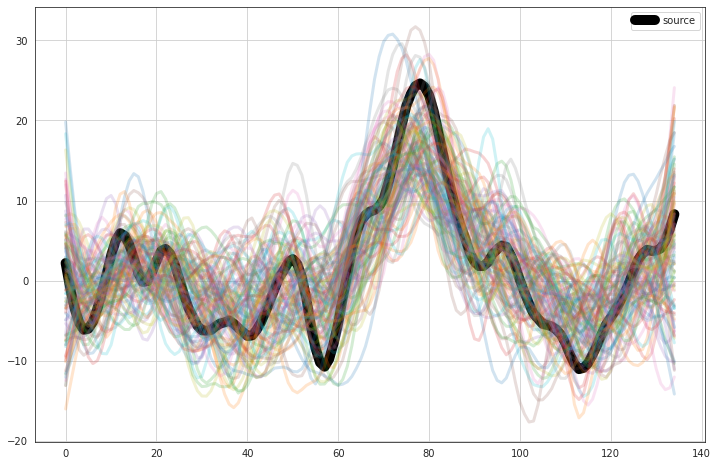

In [178]:
i = 1508
neighbor_indxs = distances[i].nonzero()[1]
neighbor_indxs = neighbor_indxs[neighbor_indxs != i]

plt.figure(figsize=(12, 8))
plt.plot(x[i], lw=10, color='k', label='source')
plt.plot(x[neighbor_indxs].T, lw=3, alpha=0.2)
plt.legend()
plt.grid()
plt.show()

#### Find label for top 30 neighbors

label source data point

In [179]:
labels[i]

'correctreject'

and its neighbors

In [180]:
labels[neighbor_indxs]

array(['falsealarm', 'correctreject', 'falsealarm', 'correctreject',
       'hit', 'correctreject', 'correctreject', 'correctreject', 'hit',
       'falsealarm', 'correctreject', 'miss', 'miss', 'correctreject',
       'correctreject', 'falsealarm', 'falsealarm', 'falsealarm',
       'correctreject', 'correctreject', 'correctreject', 'hit',
       'correctreject', 'correctreject', 'hit', 'falsealarm', 'hit',
       'correctreject', 'correctreject', 'correctreject', 'hit', 'miss',
       'correctreject', 'correctreject', 'correctreject', 'correctreject',
       'hit', 'correctreject', 'correctreject', 'hit', 'correctreject',
       'hit', 'correctreject', 'correctreject', 'correctreject', 'hit',
       'correctreject', 'correctreject', 'correctreject', 'hit', 'hit',
       'hit', 'hit', 'falsealarm', 'correctreject', 'hit', 'hit', 'hit',
       'hit', 'hit', 'correctreject', 'falsealarm', 'correctreject',
       'correctreject', 'correctreject', 'falsealarm', 'correctreject',
       'hi

#### Do neighbors have more or less the same label?

If yes, then there is information in each trace about trial types

In [181]:
coocerances = {'{:s}-{:s}'.format(t1, t2): 0 for t1 in trials for t2 in trials}

for i in tqdm(range(len(x))):
    t1 = labels[i]
    neighbor_indxs = distances[i].nonzero()[1]
    neighbor_indxs = neighbor_indxs[neighbor_indxs != i]
    for t2 in labels[neighbor_indxs]:
        key = '{:s}-{:s}'.format(t1, t2)
        coocerances[key] += 1

100%|██████████| 204736/204736 [00:27<00:00, 7487.21it/s]


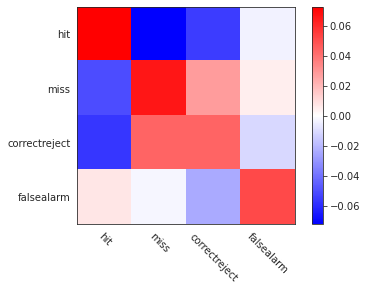

mi: 1.27e-03,  max mi: 1.19e+00


In [230]:
joint = np.zeros((len(trials), len(trials)))

for t1 in trials:
    for t2 in trials:
        key = '{:s}-{:s}'.format(t1, t2)
        joint[l2i[t1], l2i[t2]] = coocerances[key]
        
joint /= (100 * len(x))

p_x = joint.sum(1, keepdims=True) 
p_y = joint.sum(0, keepdims=True)
y_given_x = joint / p_x
x_given_y = joint / p_y

kl = y_given_x * np.log(y_given_x / p_y)
mi = p_x * y_given_x * np.log(y_given_x / p_y)
mi_max = p_x * np.eye(4) * np.log(np.eye(4) / p_y + 1e-12)

plt.imshow(np.log(joint / p_x / p_y), cmap='bwr')
plt.xticks(list(i2l.keys()), list(i2l.values()), rotation=-45)
plt.yticks(list(i2l.keys()), list(i2l.values()), rotation=0)
plt.colorbar()
plt.show()

print('mi: {:.2e},  max mi: {:.2e}'.format(mi.sum(), mi_max.sum()))

#### Conclusion: there is not much of shared structure in single cell traces as a function of trial label

### Stim frequencies

In [231]:
x = np.concatenate(dff_freq, axis=-1).T
labels = df_freq.freq.to_numpy()

In [232]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=101, radius=0.4, n_jobs=-1)
nn.fit(x)

NearestNeighbors(n_jobs=-1, n_neighbors=101, radius=0.4)

#### Connectivity matrix

In [233]:
distances = nn.kneighbors_graph(x)

#### Plot top 30 neighbors

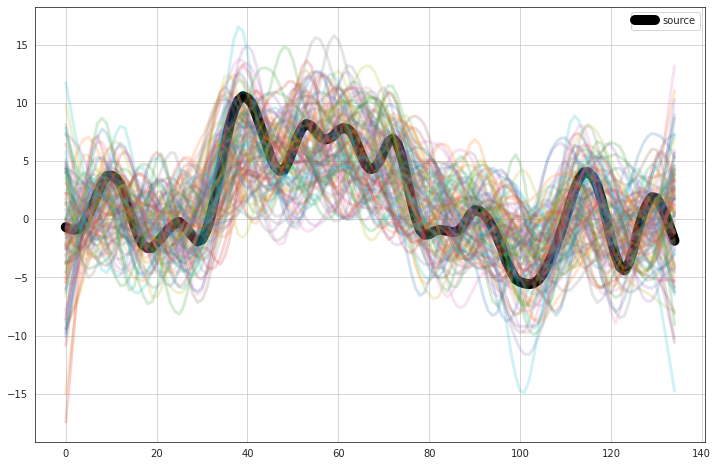

In [234]:
i = 1000
neighbor_indxs = distances[i].nonzero()[1]
neighbor_indxs = neighbor_indxs[neighbor_indxs != i]

plt.figure(figsize=(12, 8))
plt.plot(x[i], lw=10, color='k', label='source')
plt.plot(x[neighbor_indxs].T, lw=3, alpha=0.2)
plt.legend()
plt.grid()
plt.show()

#### Find label for top 30 neighbors

label source data point

In [235]:
labels[i]

9899

and its neighbors

In [236]:
labels[neighbor_indxs]

array([ 9899, 19799, 19799, 19799,  9899,  9899, 19799, 19799, 14000,
        9899,  9899,  9899, 14000, 19799,  7000, 14000,  9899,  9899,
        7000, 14000,  9899,  7000,  9899, 14000, 14000, 19799, 14000,
       19799,  7000,  9899, 14000,  7000,  7000,  9899, 19799, 19799,
        9899,  9899,  9899, 19799,  9899,  7000, 14000, 19799, 14000,
        9899,  9899,  7000, 14000,  9899, 14000,  9899, 14000, 14000,
        9899,  7000, 14000,  9899, 14000,  9899,  9899, 14000, 14000,
        7000,  7000,  9899,  9899, 14000,  9899, 19799, 19799,  7000,
       14000, 19799,  7000,  7000, 14000, 19799, 19799,  7000,  9899,
       14000, 14000, 14000, 14000, 19799,  7000, 14000, 19799,  9899,
       19799,  9899, 14000, 14000, 19799, 19799, 19799, 19799, 19799,
       14000], dtype=int16)

#### Do neighbors have more or less the same label?

If yes, then there is information in each trace about stim frequency

In [240]:
coocerances = {'{:d}-{:d}'.format(f1, f2): 0 for f1 in freqs for f2 in freqs}

for i in tqdm(range(len(x))):
    f1 = labels[i]
    neighbor_indxs = distances[i].nonzero()[1]
    neighbor_indxs = neighbor_indxs[neighbor_indxs != i]
    for f2 in labels[neighbor_indxs]:
        key = '{:d}-{:d}'.format(f1, f2)
        coocerances[key] += 1

100%|██████████| 251419/251419 [00:48<00:00, 5186.60it/s]


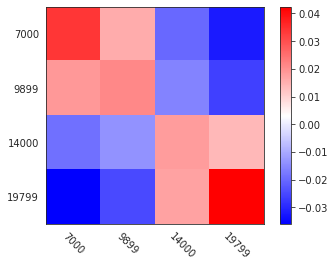

mi: 3.02e-04,  max mi: 1.39e+00


In [241]:
joint = np.zeros((len(freqs), len(freqs)))

for f1 in freqs:
    for f2 in freqs:
        key = '{:d}-{:d}'.format(f1, f2)
        joint[f2i[f1], f2i[f2]] = coocerances[key]

joint /= (100 * len(x))

p_x = joint.sum(1, keepdims=True) 
p_y = joint.sum(0, keepdims=True)
y_given_x = joint / p_x
x_given_y = joint / p_y

kl = y_given_x * np.log(y_given_x / p_y)
mi = p_x * y_given_x * np.log(y_given_x / p_y)
mi_max = p_x * np.eye(4) * np.log(np.eye(4) / p_y + 1e-12)

plt.imshow(np.log(joint / p_x / p_y), cmap='bwr')
plt.xticks(list(i2f.keys()), list(i2f.values()), rotation=-45)
plt.yticks(list(i2f.keys()), list(i2f.values()), rotation=0)
plt.colorbar()
plt.show()

print('mi: {:.2e},  max mi: {:.2e}'.format(mi.sum(), mi_max.sum()))

#### Conclusion: similarly, there is not much of shared structure in single cell traces as a function of stim frequency

However, from stucture of the joint probability distribution we see that there is information with discriminatory power encoded in individual traces that separates target with non target frequencies.  All the analysis so far hit that we must focus on population level analysis somehow.

## Simply looking at averages is misleading

There are cells that respond consistently across trials for the same trial type, but most cells have varying responses.  Below, I am plotting responses from individual cells across trials.  There are 3 horizontal dashed lines that separate trials in the following order. Top to bottom: **hit**, **miss**, **correctreject**, and **falsealaram**.  As we can see from these figures, different cells exhibit different selectivity.  Some behave almost the same during different trials, and some have clear responses that has discriminatory power.

### Example 1: a cell that is highly active during hit and falsealarm trials

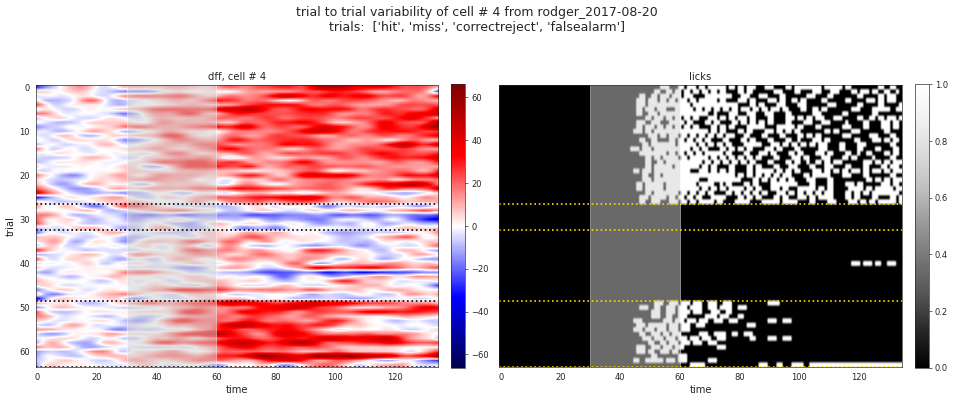

In [514]:
_ = mk_single_cell_plot(
    df=df_all,
    name="rodger_2017-08-20",
    cell=4,
    dpi=60,
)

### Example 2: a cell that is highly active during hit, but not consistently.

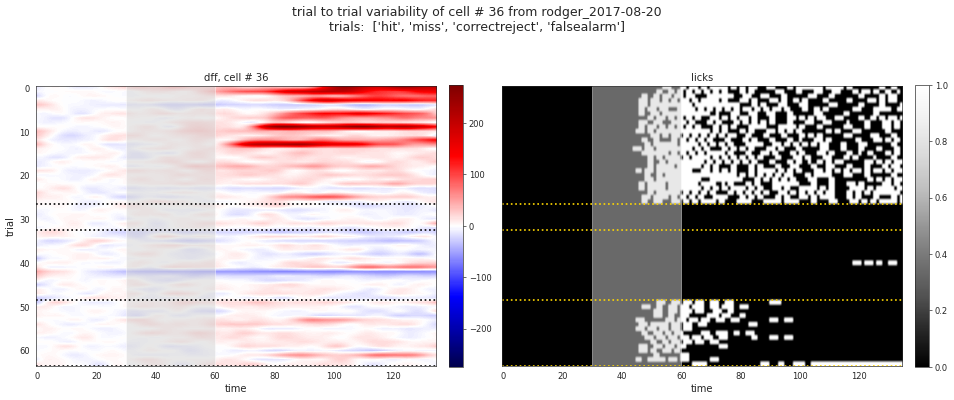

In [516]:
_ = mk_single_cell_plot(
    df=df_all,
    name="rodger_2017-08-20",
    cell=36,
    dpi=60,
)

### Example 3: excited during hit and falsealaram, inhibited during miss and correctreject

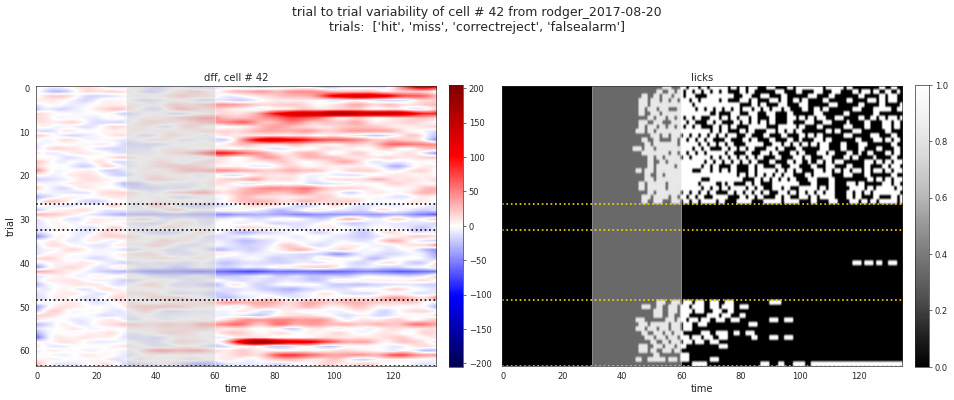

In [517]:
_ = mk_single_cell_plot(
    df=df_all,
    name="rodger_2017-08-20",
    cell=42,
    dpi=60,
)

### Example 4: seems random

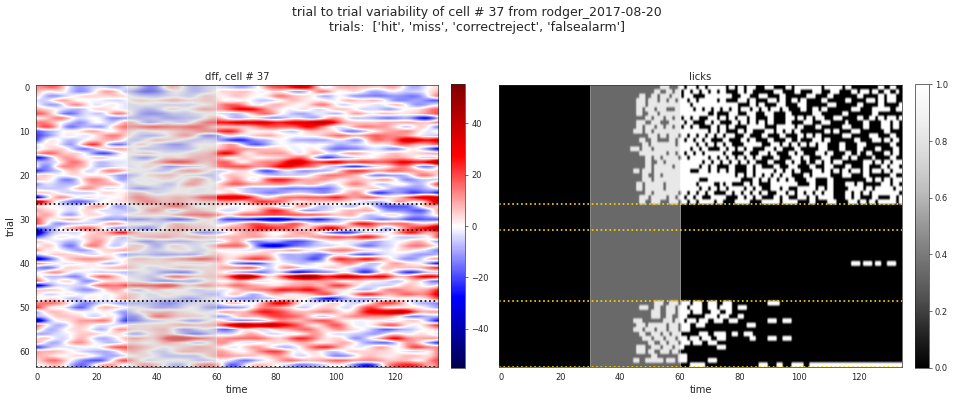

In [518]:
_ = mk_single_cell_plot(
    df=df_all,
    name="rodger_2017-08-20",
    cell=37,
    dpi=60,
)

### Example 5: highly active during correctreject, and to some extent during hit

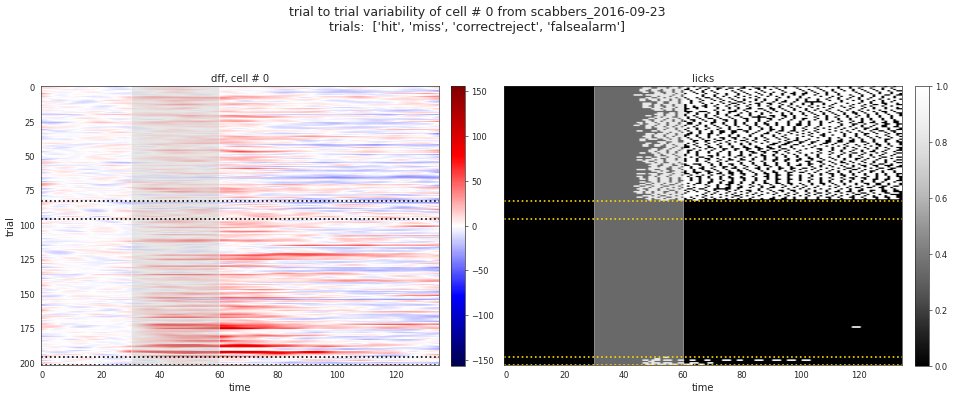

In [524]:
_ = mk_single_cell_plot(
    df=df_all,
    name="scabbers_2016-09-23",
    cell=0,
    dpi=60,
)

### Example 6: can be used to classify hit vs antything else

But even this cell shows some variance during hit trials

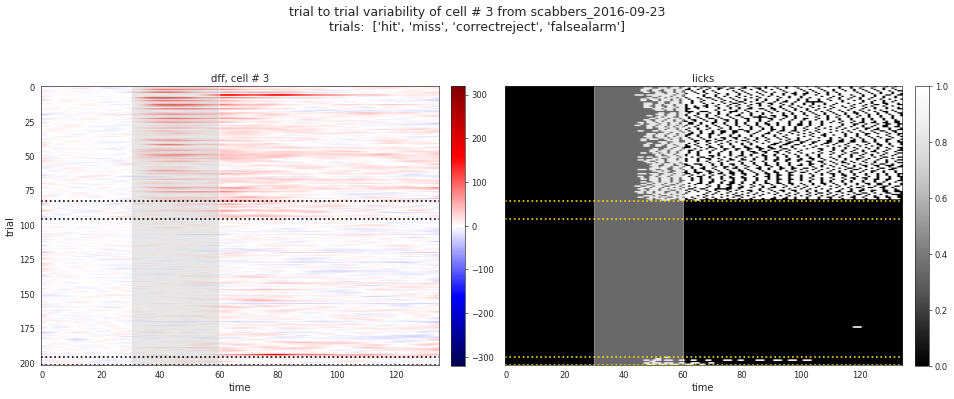

In [525]:
_ = mk_single_cell_plot(
    df=df_all,
    name="scabbers_2016-09-23",
    cell=3,
    dpi=60,
)

### Example 7: another random cell

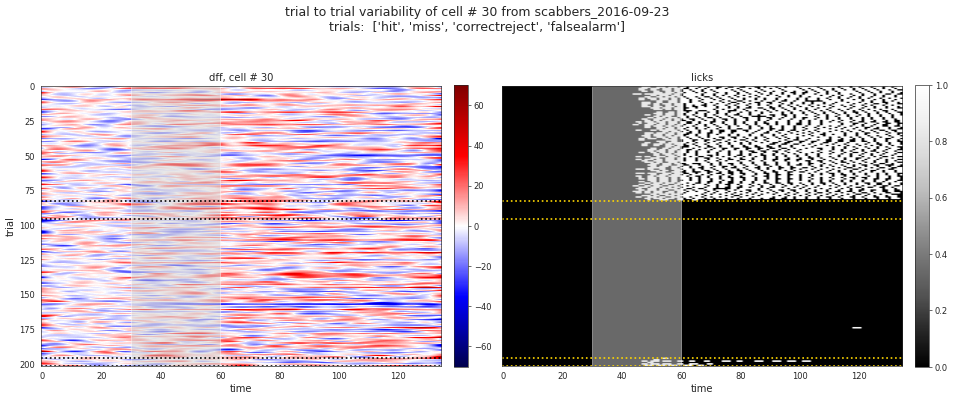

In [526]:
_ = mk_single_cell_plot(
    df=df_all,
    name="scabbers_2016-09-23",
    cell=30,
    dpi=60,
)

## Discussion

It is extremely unlikely that we will be able to detect trial labels by just looking at individual traces from individual cells.  We need a population level analysis (this is obvious, but had to check a few things to get this out of my system).  How can we do this?  A major challenge remains:

> **How can we combine datasets, knowing that each experiment is different with different number of cells. Each cell in each trial in each experiment is doing something different.**

- I'm thinking of a few possiblities, now informed by all of these analysis.  Will design simulation to test wether those ideas can work.

- I will try to concretely identify the hypothesis and assumptions to discuss and make sure they are reasonable.  Basically I'm inspired by random projection theory and [this Ganguli paper](https://www.biorxiv.org/content/10.1101/214262v2).